In [3]:
import numpy as np
import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
import matplotlib.pyplot as plt
import pyscf
from pyscf import mcscf, ao2mo, fci
#ccpvtz, ccpvqz

fcisolver = fci.direct_uhf.FCISolver()

geometries = ["""H 0.0 0.0 -0.3; H 0.0 0.0 0.3;""", 
             """H 0.0 0.0 -0.35; H 0.0 0.0 0.35;""",
             """H 0.0 0.0 -0.4; H 0.0 0.0 0.4;""",
             """H 0.0 0.0 -0.45; H 0.0 0.0 0.45;""",
             """H 0.0 0.0 -0.5; H 0.0 0.0 0.5;""",
             """H 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """H 0.0 0.0 -1.0; H 0.0 0.0 1.0;""",
             """H 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """H 0.0 0.0 -1.5; H 0.0 0.0 1.5;""",
             """H 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """H 0.0 0.0 -2.0; H 0.0 0.0 2.0;""",
             """H 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """H 0.0 0.0 -2.5; H 0.0 0.0 2.5;""",
             """H 0.0 0.0 -3.0; H 0.0 0.0 3.0;""",]#Angstrom

results_H2 = []

basis = "cc-pvdz"
cas = (2, 10) # active space
unit = "angstrom"  #angstrom, bohr

for i, geometry in enumerate(geometries):
    print(f"\nProcessing geometry {i+1}:")
    print(geometry)
    #### SlowQuant
    SQobj = sq.SlowQuant()
    SQobj.set_molecule(geometry, distance_unit=unit)
    SQobj.set_basis_set(basis)

    #### PySCF
    mol = pyscf.M(atom = geometry, basis = basis, unit = unit)
    mf = mol.RHF().run()

    #### HF 
    mo_coeffs = mf.mo_coeff

    #### get the integrals in the AO basis
    hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
    eri_4fold_ao = mol.intor('int2e_sph')

    # OO-UCCSD
    WF = WaveFunctionUCC(
    num_elec=SQobj.molecule.number_electrons,
    cas=cas,
    mo_coeffs=mo_coeffs,
    h_ao=hcore_ao,
    g_ao=eri_4fold_ao,
    excitations="SD",
    include_active_kappa=True,
    )

    hcore_mo = np.einsum('pi,pq,qj->ij', mo_coeffs, hcore_ao, mo_coeffs)
    eri_4fold_mo = ao2mo.incore.full(eri_4fold_ao, mo_coeffs)
    
    energy_fci, coefficients = fcisolver.kernel(
            h1e=(hcore_mo, hcore_mo),  
            eri=(eri_4fold_mo, eri_4fold_mo, eri_4fold_mo),  
            norb=10,
            nelec=(1, 1),
            nroots=1
    )

    
    WF.run_wf_optimization_1step(
    		optimizer_name="SLSQP", 
    		tol = 1e-8,
    		orbital_optimization=False)
   
    energy_uccsd = WF.energy_elec + mol.energy_nuc()

    print(f"UCCSD energy for geometry {i+1} = {energy_uccsd}")
  
    results_H2.append({
        'geometry': geometry,
        'energy uccsd': energy_uccsd,
        'energy fci': energy_fci + mol.energy_nuc(),
        'nuclear_repulsion': mol.energy_nuc(),
        'electronic_energy': WF.energy_elec
    })

    with open('results_pvdz_H2.json', 'w') as f:
        json.dump(results_H2, f, indent=4)  
    




Processing geometry 1:
H 0.0 0.0 -0.3; H 0.0 0.0 0.3;
converged SCF energy = -1.10689247514485
-2.0211353114880746
### Parameters information:
### Number kappa: 0
### Number theta1: 9
### Number theta2: 45
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 54

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         1.12       |     -1.1132686560330234    
--------     2      |         1.13       |     -1.4702793991540049    
--------     3      |         1.27       |     -1.9571037148675190    
--------     4      |         1.19       |     -2.0115245311256027    
--------     5      |         1.07       |     -2.0177778922106473    
--------     6      |         1.25       |     -2.0209529868346152    
--------     7      |         1.17       |     -2.0209998225401957    
--------     8      |         1.19       |     -2.0210480734922998    
--------     9      |         1.14       |     -2.02

In [1]:
import json

### CC-PVDZ
with open('results_true_pvdz_H2.json', 'r') as f:
    loaded_results_true_pvdz_H2 = json.load(f)

with open('results_false_pvdz_H2.json', 'r') as f:
    loaded_results_false_pvdz_H2 = json.load(f)

print(f'Results for CC-PVDZ')
print()
print(loaded_results_true_pvdz_H2)
print()
print(loaded_results_false_pvdz_H2) 



Results for CC-PVDZ

[{'geometry': 'H 0.0 0.0 -0.3; H 0.0 0.0 0.3;', 'energy': -1.1391732926525802, 'nuclear_repulsion': 0.8819620182000001, 'electronic_energy': -2.0211353108525802}, {'geometry': 'H 0.0 0.0 -0.35; H 0.0 0.0 0.35;', 'energy': -1.1609046798058227, 'nuclear_repulsion': 0.7559674441714287, 'electronic_energy': -1.9168721239772513}, {'geometry': 'H 0.0 0.0 -0.4; H 0.0 0.0 0.4;', 'energy': -1.162750760345864, 'nuclear_repulsion': 0.66147151365, 'electronic_energy': -1.824222273995864}, {'geometry': 'H 0.0 0.0 -0.45; H 0.0 0.0 0.45;', 'energy': -1.1540817044694682, 'nuclear_repulsion': 0.5879746788, 'electronic_energy': -1.7420563832694682}, {'geometry': 'H 0.0 0.0 -0.5; H 0.0 0.0 0.5;', 'energy': -1.1400734791679352, 'nuclear_repulsion': 0.52917721092, 'electronic_energy': -1.6692506900879351}, {'geometry': 'H 0.0 0.0 -0.75; H 0.0 0.0 0.75;', 'energy': -1.0615349493458015, 'nuclear_repulsion': 0.35278480728, 'electronic_energy': -1.4143197566258014}, {'geometry': 'H 0.0 0.0

In [2]:
### CC-PVTZ

with open('results_true_pvtz_H2.json', 'r') as f:
    loaded_results_true_pvtz_H2 = json.load(f)

with open('results_false_pvtz_H2.json', 'r') as f:
    loaded_results_false_pvtz_H2 = json.load(f)

print()
print(f'Results for CC-PVTZ')
print()
print(loaded_results_true_pvtz_H2)
print()
print(loaded_results_false_pvtz_H2) 


Results for CC-PVTZ

[{'geometry': 'H 0.0 0.0 -0.3; H 0.0 0.0 0.3;', 'energy': -1.1518561397185942, 'nuclear_repulsion': 0.8819620182000001, 'electronic_energy': -2.0338181579185943}, {'geometry': 'H 0.0 0.0 -0.35; H 0.0 0.0 0.35;', 'energy': -1.169448817594577, 'nuclear_repulsion': 0.7559674441714287, 'electronic_energy': -1.9254162617660056}, {'geometry': 'H 0.0 0.0 -0.4; H 0.0 0.0 0.4;', 'energy': -1.168973159014975, 'nuclear_repulsion': 0.66147151365, 'electronic_energy': -1.830444672664975}, {'geometry': 'H 0.0 0.0 -0.45; H 0.0 0.0 0.45;', 'energy': -1.1591258653114773, 'nuclear_repulsion': 0.5879746788, 'electronic_energy': -1.7471005441114773}, {'geometry': 'H 0.0 0.0 -0.5; H 0.0 0.0 0.5;', 'energy': -1.1446285037919317, 'nuclear_repulsion': 0.52917721092, 'electronic_energy': -1.6738057147119318}, {'geometry': 'H 0.0 0.0 -0.75; H 0.0 0.0 0.75;', 'energy': -1.0657169557084665, 'nuclear_repulsion': 0.35278480728, 'electronic_energy': -1.4185017629884664}, {'geometry': 'H 0.0 0.0

In [4]:
with open('results_pvdz_H2.json', 'r') as f:
    loaded_pvdz_H2 = json.load(f)
print(loaded_pvdz_H2)

[{'geometry': 'H 0.0 0.0 -0.3; H 0.0 0.0 0.3;', 'energy uccsd': -1.1391732928095377, 'energy fci': -1.1391732932880745, 'nuclear_repulsion': 0.8819620182000001, 'electronic_energy': -2.021135311009538}, {'geometry': 'H 0.0 0.0 -0.35; H 0.0 0.0 0.35;', 'energy uccsd': -1.160904681632466, 'energy fci': -1.160904682478467, 'nuclear_repulsion': 0.7559674441714287, 'electronic_energy': -1.9168721258038948}, {'geometry': 'H 0.0 0.0 -0.4; H 0.0 0.0 0.4;', 'energy uccsd': -1.1627507619452209, 'energy fci': -1.1627507630227372, 'nuclear_repulsion': 0.66147151365, 'electronic_energy': -1.8242222755952209}, {'geometry': 'H 0.0 0.0 -0.45; H 0.0 0.0 0.45;', 'energy uccsd': -1.1540817034080642, 'energy fci': -1.154081706119978, 'nuclear_repulsion': 0.5879746788, 'electronic_energy': -1.7420563822080641}, {'geometry': 'H 0.0 0.0 -0.5; H 0.0 0.0 0.5;', 'energy uccsd': -1.1400734802918735, 'energy fci': -1.1400734808760387, 'nuclear_repulsion': 0.52917721092, 'electronic_energy': -1.6692506912118734}, 

In [1]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
from pyscf import fci
import matplotlib.pyplot as plt
import numpy as np

covos = [18]

for covo in covos:
    print('{} COVOs'.format(covo))
    # we start by defining the paths to the files
    data_dir_nwchem = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo'.format(covo))
    data_dir_yaml = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo))
    if not os.path.exists(data_dir_yaml): # we create a pathto store yaml files if it doesn't exist
        os.makedirs(os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo)))
    data_files = os.listdir(data_dir_nwchem) # this include all the files in data_dir_nwchem
    bond_distances = []


    for data_file in data_files:
        if data_file.find('out') == -1: # we only use those with .out in the name, the output files
            continue
        # define some values to build the name of the .yaml file   
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        name = temp[0] + '-' + str(bond_distance)
        print("========= Bond distance: {} =========".format(bond_distance))
        data_file_yaml = os.path.join(data_dir_yaml, "{}.yaml".format(name))  # create the empty .yaml file in data_dir_yaml   
        
        data = extract_fields(os.path.join(data_dir_nwchem,data_file)) # data extracts the information from the output file 
        
        with open(data_file_yaml, 'w') as f:
            f.write(yaml.dump(data, default_flow_style=False)) # we write the extracted data into the .yaml file so we can work with it
            

18 COVOs
========= Bond distance: 1.0 =========
========= Bond distance: 0.7 =========
========= Bond distance: 0.9 =========
========= Bond distance: 3.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 3.0 =========
========= Bond distance: 5.0 =========
========= Bond distance: 4.0 =========
========= Bond distance: 0.6 =========
========= Bond distance: 4.5 =========
========= Bond distance: 0.8 =========
========= Bond distance: 1.5 =========


In [4]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
from pyscf import fci, mcscf, ao2mo
import matplotlib.pyplot as plt

import json
import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC
import pyscf
import customized_exp_kappa as kappa


hf_orbitals = SQobj.hartree_fock.mo_coeff # Hartree-Fock orbitals


#-------MP2--------#
mymp = pyscf.mp.MP2(myhf).run()
mymp.kernel()
mp2_noons, mp2_natorbs = pyscf.mcscf.addons.make_natural_orbitals(mymp) # MP2 oribtals
#------------------#


#-------Random--------#
num_orbs = len(hf_orbitals) 
num_inactive_orbs = 0 #OBS!!! Remember to add the correct number of inactive orbitals! 
num_active_orbs = cas[1]
kappa_elements = np.random.random_sample((int(num_orbs * (num_orbs - 1) / 2),))
exp_kappa = kappa.construct_exp_kappa_matrix(num_orbs = num_orbs, num_inactive_orbs = num_inactive_orbs, num_active_orbs = num_active_orbs, kappa_elements = kappa_elements)
random_start_guess = hf_orbitals@exp_kappa # c'=cU
print(kappa_elements)
print(exp_kappa)
#--------------------#


fcisolver = fci.direct_uhf.FCISolver()

covos = [1,2,4,8,10,12,18]

data_covos={}
for covo in covos:
    print(f'{covo} COVOs')
    data_dir_yaml = os.path.join("..","data","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo))
    data_files = os.listdir(data_dir_yaml)
    bond_distances = []
    total_energies_uccsd = []
    total_energies_fci = []
    
    for data_file in data_files:
        if not data_file.endswith('.yaml'):
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        print(f"========= Bond distance: {bond_distance} =========")      
        yaml_file = os.path.join(data_dir_yaml, "H2-5.0.yaml")
        driver = nwchem_driver.NWchem_Driver(yaml_file)
        n_electrons, n_spatial_orbitals, nuclear_repulsion_energy, h1, h2 = driver.load_from_yaml(yaml_file, include_spin=False)

        WF = WaveFunctionUCC(
             num_elec=n_electrons,
             cas=(2,10),
             mo_coeffs=np.identity(n_spatial_orbitals),
             c_orthonormal = random_start_guess, 
             h_ao=h1,
             g_ao=h2,
             excitations="SD",
             include_active_kappa=True,
             )
        
        WF.run_wf_optimization_1step(
             optimizer_name="SLSQP", 
       	     tol = 1e-6,
       		 orbital_optimization=False)
        
        energy_fci, coefficients = fcisolver.kernel(
             h1e=(h1, h1),  
             eri=(h2, h2, h2),  
             norb=n_spatial_orbitals,
             nelec=(1, 1),
             nroots=1
            )

        total_energies_uccsd.append(WF.energy_elec + nuclear_repulsion_energy)
        total_energies_fci.append(energy_fci + nuclear_repulsion_energy)  

    total_energies_uccsd = np.array(total_energies_uccsd)
    bond_distances = np.array(bond_distances)
    total_energies_fci = np.array(total_energies_fci)

    sorted_indices = np.argsort(bond_distances)
    bond_distances = bond_distances[sorted_indices]
    total_energies_uccsd = total_energies_uccsd[sorted_indices]
    total_energies_fci = total_energies_fci[sorted_indices]

    data_covos[covo] = np.array([bond_distances, total_energies_uccsd, total_energies_fci])

with open('results_covo_H2.json', 'w') as f:
     json.dump(data_covos, f, indent=4)  

18 COVOs
### Parameters information:
### Number kappa: 0
### Number theta1: 9
### Number theta2: 45
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 54

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |        11.85       |     -0.9449540882978513    
--------     2      |         8.30       |     -1.0870210146294566    
--------     3      |         7.95       |     -1.0940809361855299    
--------     4      |         7.85       |     -1.1018113487676628    
--------     5      |         9.25       |     -1.1017855571878123    
--------     6      |        11.64       |     -1.1018835380070842    
--------     7      |         7.99       |     -1.1018863398749095    
--------     8      |         3.98       |     -1.1018863398749095    
{18: array([], shape=(3, 0), dtype=float64)}


In [12]:
print(energy_fci + nuclear_repulsion_energy)

-0.9972583699392279


In [44]:
import json

# Crear una copia de data_covos con arreglos convertidos a listas
data_covos_serializable = {str(key): [arr.tolist() for arr in value] for key, value in data_covos.items()}

# Guardar en JSON
#with open('results_covo_H2.json', 'w') as f:
    #json.dump(data_covos_serializable, f, indent=4)

In [5]:
with open('results_covo_H2.json', 'r') as f:
    energies_covo_H2 = json.load(f)
with open('results_pvdz_H2.json', 'r') as f:
    loaded_pvdz_H2 = json.load(f)

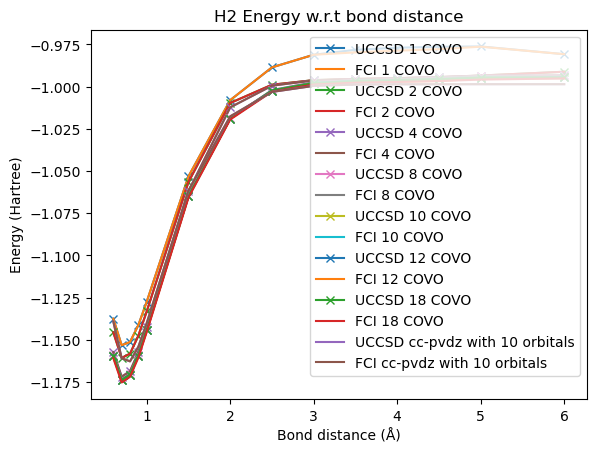

In [7]:
import matplotlib.pyplot as plt

energies_uccsd_pvdz_H2 = [result['energy uccsd'] for result in loaded_pvdz_H2]   
energies_fci_pvdz_H2 = [result['energy fci'] for result in loaded_pvdz_H2] 

for covo in energies_covo_H2:
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][1], 'x-', label=f'UCCSD {covo} COVO')
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][2], label=f'FCI {covo} COVO')
plt.plot(energies_covo_H2[covo][0],energies_uccsd_pvdz_H2, label='UCCSD cc-pvdz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_fci_pvdz_H2, label='FCI cc-pvdz with 10 orbitals')
plt.legend(loc=1)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('H2 Energy w.r.t bond distance')
#plt.ylim([-1.18,-0.8])
plt.savefig('H2_COVO.png')
plt.show()


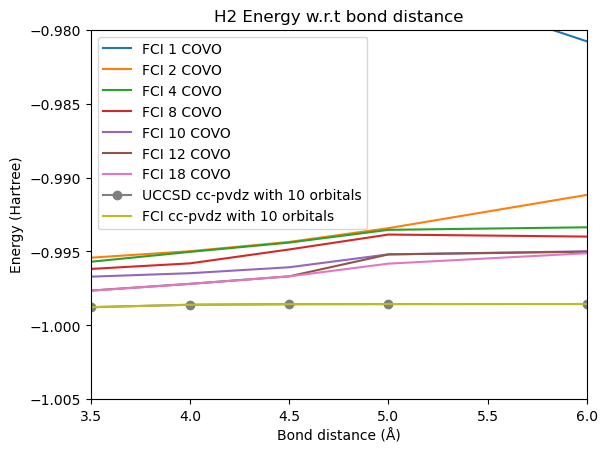

In [44]:
for covo in energies_covo_H2:
    #plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][1], 'x-', label=f'UCCSD {covo} COVO')
    plt.plot(energies_covo_H2[covo][0], energies_covo_H2[covo][2], label=f'FCI {covo} COVO')
plt.plot(energies_covo_H2[covo][0],energies_uccsd_pvdz_H2, 'o-', label='UCCSD cc-pvdz with 10 orbitals')
plt.plot(energies_covo_H2[covo][0],energies_fci_pvdz_H2,  label='FCI cc-pvdz with 10 orbitals')
plt.legend(loc=2)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Energy (Hartree)')
plt.title('H2 Energy w.r.t bond distance')
plt.ylim([-1.005,-0.98])
plt.xlim([3.5,6.0])
plt.savefig('H2_COVO__.png')
plt.show()

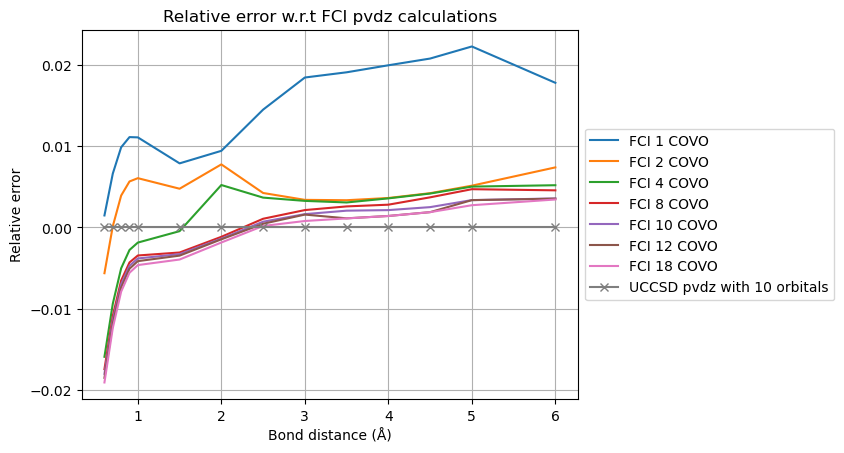

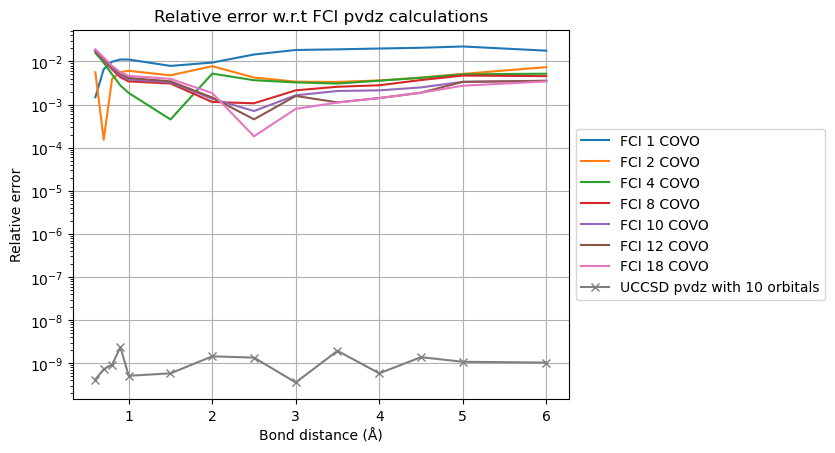

In [47]:
errors_uccsd_H2 = {}
errors_fci_H2 = {}

energies_fci_pvdz_H2 = np.array(energies_fci_pvdz_H2)
energies_uccsd_pvdz_H2 = np.array(energies_uccsd_pvdz_H2)


for covo in energies_covo_H2:
    errors_uccsd_H2[covo] =(energies_covo_H2[covo][1] - energies_fci_pvdz_H2)/np.abs(energies_fci_pvdz_H2)
    errors_fci_H2[covo] = (energies_covo_H2[covo][2] - energies_fci_pvdz_H2)/np.abs(energies_fci_pvdz_H2)

error_pvdz_uccsd_H2 = (energies_uccsd_pvdz_H2 - energies_fci_pvdz_H2)/np.abs(energies_fci_pvdz_H2)

for covo in errors_fci_H2:
    #plt.plot(energies_covo_H2[covo][0], errors_uccsd_H2[covo], 'o-', label=f'UCCSD {covo} COVO')  
    plt.plot(energies_covo_H2[covo][0], errors_fci_H2[covo],  label=f'FCI {covo} COVO')  

plt.plot(energies_covo_H2[covo][0], error_pvdz_uccsd_H2, 'x-', label = 'UCCSD pvdz with 10 orbitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Relative error')
plt.title('Relative error w.r.t FCI pvdz calculations')
plt.savefig('error_covo.png')
plt.show()

for covo in errors_fci_H2:
    #plt.semilogy(energies_covo_H2[covo][0], errors_uccsd_H2[covo], 'o-', label=f'UCCSD {covo} COVO')  
    plt.semilogy(energies_covo_H2[covo][0], np.abs(errors_fci_H2[covo]),  label=f'FCI {covo} COVO')  

plt.semilogy(energies_covo_H2[covo][0], np.abs(error_pvdz_uccsd_H2), 'x-', label = 'UCCSD pvdz with 10 orbitals')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Relative error')
plt.title('Relative error w.r.t FCI pvdz calculations')
plt.savefig('error_covo_log.png')
plt.show()

{'1': array([1.94073759e-11, 4.09020524e-07, 1.24029813e-07, 1.44282909e-08,
       7.32678245e-12, 3.31644464e-13, 1.82402062e-08, 1.14640552e-10,
       4.91475874e-09, 1.56918229e-03, 1.78012802e-03, 1.46487163e-03,
       1.24938285e-04, 6.54176609e-09]), '2': array([1.12670091e-07, 1.66317308e-07, 1.55290896e-08, 2.16427226e-07,
       1.50360439e-07, 9.87233071e-08, 3.37849928e-07, 1.32277455e-08,
       4.14396206e-07, 2.51099226e-07, 2.36070796e-07, 1.66184208e-07,
       2.63094166e-07, 8.37999896e-08]), '4': array([2.13354089e-13, 3.03564926e-13, 1.44977929e-13, 2.13573118e-07,
       1.97606276e-07, 5.23950371e-08, 2.49984281e-07, 7.99198767e-09,
       1.84676530e-08, 2.64737572e-07, 1.28579585e-07, 6.31759356e-08,
       1.37955665e-07, 2.96484537e-08]), '8': array([3.08850621e-08, 6.50103353e-09, 3.40724870e-08, 4.67248769e-07,
       2.72984216e-07, 4.36467022e-08, 6.88786404e-08, 1.09632299e-07,
       1.07834600e-07, 5.63738674e-08, 2.81870539e-07, 7.23921436e-08,
    

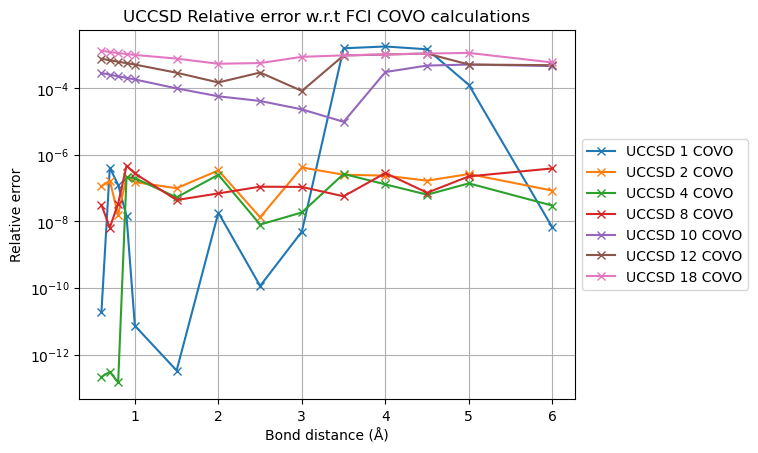

In [38]:
error_covos = {}

for covo in energies_covo_H2:
    
    energy_covo_uccsd = np.array(energies_covo_H2[covo][1])
    energy_covo_fci = np.array(energies_covo_H2[covo][2])
    
    error_covos[covo] = np.abs(energy_covo_uccsd - energy_covo_fci)/np.abs(energy_covo_fci)
    
print(error_covos)
for covo in energies_covo_H2:
    plt.semilogy(energies_covo_H2[covo][0], error_covos[covo], 'x-', label = f'UCCSD {covo} COVO')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.xlabel('Bond distance (Å)')
plt.ylabel('Relative error')
plt.title('UCCSD Relative error w.r.t FCI COVO calculations')
plt.savefig('error_covo_uccsd.png')
plt.show()